In [2]:
import tensorflow as tf
keras = tf.keras
from keras.preprocessing.text import Tokenizer
from keras import layers, models

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import pandas as pd

np.random.seed(999)

# 1 Data
For this assignment, I am using the Fake news dataset from Kaggle. The dataset contains articles' titles, text, etc. and contains labels that indicate whether the article is "fake news" or not. We can see from the pie chart that both classes are relatively equally distributed.

In [ ]:
fake = pd.read_csv('data/Fake.csv')
true = pd.read_csv('data/True.csv')
fake["label"] = 1
true["label"] = -1 # Fake news is 1, true news is -1
true.head()

# Concatenate the dataframes
df = pd.concat([fake, true])
df["full text"] = df["title"] + df["text"]


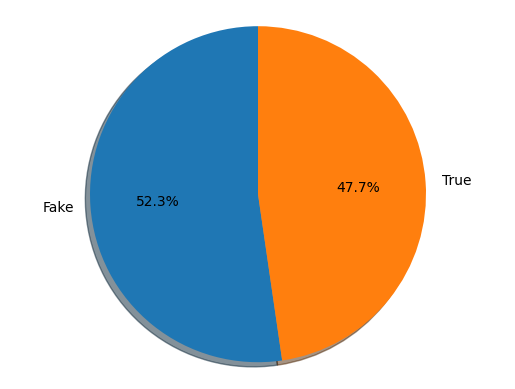

In [5]:
import matplotlib.pyplot as plt



# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Fake", "True"]
sizes = [len(fake), len(true)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


# 2 Sequential Model
In the following cell, I implement a simple single hidden layer sequential neural network. I tested multiple different vocabulary sizes. The best results were achieved with 100,000 vocabulary words, however the model achieved 100% accuracy with this, which indicates that it is incredibly overfitted. I found that 25,000 was a happy medium.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def cnn(num_labels = 2, vocab_size = 2000, batch_size = 100, input_column = "title"):
    i = np.random.rand(len(df)) < 0.8
    train = df[i]
    test = df[~i]
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(train[input_column])

    x_train = tokenizer.texts_to_matrix(train[input_column], mode="tfidf")
    x_test = tokenizer.texts_to_matrix(test[input_column], mode="tfidf")

    encoder = LabelEncoder()
    encoder.fit(train.label)
    y_train = encoder.transform(train.label)
    y_test = encoder.transform(test.label)
    model = models.Sequential()

    model.add(layers.Dense(64, input_dim=vocab_size, kernel_initializer="normal", activation="relu"))
    model.add(layers.Dense(1, kernel_initializer="normal", activation="sigmoid"))

    model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
    history = model.fit(x_train, y_train, 
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1)

    pred = model.predict(x_test)
    pred_labels = [1 if p>0.5 else 0 for p in pred]
    print('accuracy score: ', accuracy_score(y_test, pred_labels))
    print('precision score: ', precision_score(y_test, pred_labels))
    print('recall score: ', recall_score(y_test, pred_labels))
    print('f1 score: ', f1_score(y_test, pred_labels))

for vocab_size in [25000]:#[100, 5000, 10000, 25000, 50000, 100000]:
    cnn(vocab_size=vocab_size, input_column="full text")
                    

# 3 Changing Architecture
In this section, I implemented both a convolutional neural net and recursive neural net. 

## Convolutional Neural Net
This has SIGNIFICANTLY lower performance than the simple sequential neural net. I believe this is because this text classification task requires the full context of the article, but the convolutions somehow reduce the amount of context given.

In [ ]:
num_labels = 2
vocab_size = 2000
batch_size = 100
input_column = "title"

max_features = 10000

i = np.random.rand(len(df)) < 0.8
train = df[i]
test = df[~i]
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train[input_column])

x_train = tokenizer.texts_to_matrix(train[input_column], mode="tfidf")
x_test = tokenizer.texts_to_matrix(test[input_column], mode="tfidf")

encoder = LabelEncoder()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

embedding_dim = 16
max_sequence_length = 2000
model = models.Sequential([
  layers.Embedding(max_features + 1, embedding_dim, input_length=max_sequence_length),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])



model.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])
history = model.fit(x_train, y_train, 
                batch_size=batch_size,
                epochs=100,
                verbose=1,
                validation_split=0.1)

pred = model.predict(x_test)
pred_labels = [1 if p>0.5 else 0 for p in pred]
print('accuracy score: ', accuracy_score(y_test, pred_labels))
print('precision score: ', precision_score(y_test, pred_labels))
print('recall score: ', recall_score(y_test, pred_labels))
print('f1 score: ', f1_score(y_test, pred_labels))

## Recurrent Neural Network
Similar to CNNs, this also has significantly lower performance than the sequential neural net. However, the RNN delivers better accuracy on the test set.

In [ ]:
num_labels = 2
vocab_size = 2000
batch_size = 100
input_column = "title"

max_features = 10000

i = np.random.rand(len(df)) < 0.8
train = df[i]
test = df[~i]
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train[input_column])

x_train = tokenizer.texts_to_matrix(train[input_column], mode="tfidf")
x_test = tokenizer.texts_to_matrix(test[input_column], mode="tfidf")

encoder = LabelEncoder()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

embedding_dim = 16
max_sequence_length = 2000
model = models.Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


model.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])
history = model.fit(x_train, y_train, 
                batch_size=batch_size,
                epochs=100,
                verbose=1,
                validation_split=0.1)

pred = model.predict(x_test)
pred_labels = [1 if p>0.5 else 0 for p in pred]
print('accuracy score: ', accuracy_score(y_test, pred_labels))
print('precision score: ', precision_score(y_test, pred_labels))
print('recall score: ', recall_score(y_test, pred_labels))
print('f1 score: ', f1_score(y_test, pred_labels))

# 4 Different Embedding
In this cell, I return to the sequential neural network model and use the Tensorflow embedding instead of the SKLearn LabelEncoder. I did not see much of a difference with respect to performance while switching.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization



i = np.random.rand(len(df)) < 0.8
train = df[i]
test = df[~i]
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train[input_column])


vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
x_train = vectorizer(np.array([[s] for s in train])).numpy()
x_val = vectorizer(np.array([[s] for s in train])).numpy()

text_ds = tf.data.Dataset.from_tensor_slices(train).batch(128)
vectorizer.adapt(text_ds)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)
model = models.Sequential()

model.add(layers.Dense(64, input_dim=vocab_size, kernel_initializer="normal", activation="relu"))
model.add(layers.Dense(1, kernel_initializer="normal", activation="sigmoid"))

model.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])
history = model.fit(x_train, y_train, 
                batch_size=batch_size,
                epochs=30,
                verbose=1,
                validation_split=0.1)

pred = model.predict(x_test)
pred_labels = [1 if p>0.5 else 0 for p in pred]
print('accuracy score: ', accuracy_score(y_test, pred_labels))
print('precision score: ', precision_score(y_test, pred_labels))
print('recall score: ', recall_score(y_test, pred_labels))
print('f1 score: ', f1_score(y_test, pred_labels))


# 5 Analysis
From my experiments in this notebook, I have found that a simple sequential neural network is the best for the text classification task I am attempting to perform. I am hesitant to say that, because the 100,000 parameter model clearly exhibited overfitting. The convolutional neural network architecture showed a significant decrease in accuracy, at the cost of significantly higher computational resources. In my experience, the RNN model also costed too much computational power, thus I believe that the sequential neural network is the ideal choice for this task. It trains relatively quickly, has the best results, and can run on my laptop!